In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
#models import
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression



lets define some function that will be useful for us

function that prepare the RightHand data 

In [2]:
def prepare_data_hand_right(df):
    df['Type'] = 1
    df = df.dropna()
    df.rename(str.strip, axis='columns', inplace=True)
    add_wanted_columns(df)
    df.drop(['Time', 'Frame ID', 'Hand Type', '# hands'], axis = 1, inplace = True)
    df = df.add_suffix(' right')
    return df

function for combine 1 frame (2 samples in our data) into 1 sample

In [3]:
def combine_two_samples(df):
    hand_left = pd.DataFrame()
    hand_right = pd.DataFrame()
    for i in range(len(df)):
        if (i%2 == 0):
            hand_left = pd.concat([hand_left, df.iloc[i:i+1]])
        else:
            hand_right = pd.concat([hand_right, df.iloc[i:i+1]])
    hand_left = hand_left.add_suffix(' left')
    hand_right = hand_right.add_suffix(' right')
    hand_left.set_index(np.arange(len(hand_left)), inplace=True)
    hand_right.set_index(np.arange(len(hand_right)), inplace=True)
    result = pd.concat([hand_left, hand_right], axis=1, join='inner')
    return result

main function for preparing the data so we can use them

In [4]:
def prepare_data(df, df_path):
    df['Type'] = sync_type(df_path)
    df = df.dropna()
    df.rename(str.strip, axis='columns', inplace=True)
    add_wanted_columns(df)
    df = df[df['Time']>=df['Time'].values[0]+7]
    total_time = df.iloc[len(df)-1,0] - df.iloc[0,0]
    number_of_jumps = int(total_time//3)
    df.drop(['Time', 'Frame ID', 'Hand Type', '# hands'], axis = 1, inplace=True)
    i=0
    df2 = pd.DataFrame()
    if df['Type'].values[0] == 1 :
        while(i*number_of_jumps<len(df)):
            df2 = pd.concat([df2,df.iloc[i*number_of_jumps:i*number_of_jumps+1]])
            i=i+1
        df2 = df2.add_suffix(' left')
        result = pd.concat([df2, df_right_hand], axis=1, join='inner')
        return result
    
    else:
        while(i*number_of_jumps<len(df)):
            df2 = pd.concat([df2,df.iloc[i*number_of_jumps:(i*number_of_jumps)+2]])
            i=i+1
        return combine_two_samples(df2)


function that return if its Sync, Spontan or Alone data

In [5]:
def sync_type(path_name):
    if "Sync" in path_name:
        return 3
    if "Spontan" in path_name:
        return 2
    return 1


<pre>
label     sync_type  
1         Alone
2         Spontan
3         Sync
</pre>

function for adding the delta X,Y,Z as we want

In [6]:
def add_wanted_columns(df):
    df['deltaX'] = df['Position X']
    df['deltaY'] = df['Position Y']
    df['deltaZ'] = df['Position Z']

    for i in range(2, len(df)):
        df['deltaX'][i] = abs(df['Position X'][i] - df['Position X'][i-2])
        df['deltaY'][i] = abs(df['Position Y'][i] - df['Position Y'][i-2])
        df['deltaZ'][i] = abs(df['Position Z'][i] - df['Position Z'][i-2])
    

In [7]:
def evaluate_pred(arr):
    eval = 0;
    for i in range(len(arr)):
        for j in range(len(arr[0])):
            if i==j :
                eval = eval + arr[i][j]
            else:
                eval = eval - arr[i][j]
    return eval

In [8]:
df_right_hand = pd.read_csv('Data\HandRight.csv')
df_right_hand = prepare_data_hand_right(df_right_hand)
df_right_hand

final_training_df = pd.DataFrame()
for name in glob.glob("Data\Training\*\*"):
    df = pd.read_csv(name)
    df = prepare_data(df, name)
    final_training_df = pd.concat([final_training_df,df], ignore_index=True)

In [9]:
final_validation_df = pd.DataFrame()
for name in glob.glob("Data\Validation\*\*"):
    df = pd.read_csv(name)
    df = prepare_data(df, name)
    final_validation_df = pd.concat([final_validation_df,df], ignore_index=True)
df_validation = final_validation_df

In [10]:
final_training_df

,Position X left,Position Y left,Position Z left,Velocity X left,Velocity Y left,Velocity Z left,Pitch left,Roll left,Yaw left,Wrist Pos X left,...,Elbow pos X right,Elbow Pos Y right,Elbow Pos Z right,Grab Strenth right,Grab Angle right,Pinch Strength right,Type right,deltaX right,deltaY right,deltaZ right
0,-109.80610,228.3820,87.325780,-41.538020,116.707100,-60.097880,2.147859,0.867143,2.206444,-154.8575,...,313.4828,3.741617,144.85630,0.000000,0.229723,0.0,2,0.01470,4.6275,2.435660
1,-115.70580,261.6903,70.856630,-65.676760,119.218100,-127.765400,1.864342,0.961080,2.000273,-156.9426,...,344.2592,8.226139,108.72380,0.000000,0.226765,0.0,2,2.14530,4.0526,8.396210
2,-122.71470,276.9030,75.847070,-35.656000,-7.543404,253.068200,1.820573,1.066452,2.039683,-158.0364,...,336.3046,1.021556,119.80650,0.000000,0.400378,0.0,2,0.46860,0.2318,0.768190
3,-121.84830,236.1788,112.223700,33.917680,-192.210300,-5.061764,2.245878,0.906889,2.451392,-157.5753,...,352.8090,7.420822,102.02480,0.000000,0.372209,0.0,2,2.30050,2.0726,0.390320
4,-121.64220,251.4100,96.457120,31.320550,121.569700,-150.245300,2.105439,0.901632,2.268401,-161.1734,...,341.4695,-10.106060,96.04390,0.181345,0.915438,0.0,2,1.38510,4.2098,7.215600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13614,-77.65361,213.3658,6.923586,21.649800,-63.049120,-43.615220,1.309460,1.360157,0.720759,-100.7091,...,302.5687,-45.943390,64.31937,0.000000,0.000000,0.0,3,0.90834,1.3162,2.965010
13615,-77.40852,196.4212,-2.592364,19.632120,-79.734180,-31.711440,1.009325,1.544355,0.540403,-103.8873,...,299.6021,-51.142870,44.86131,0.000000,0.000000,0.0,3,0.23127,0.2931,3.883060
13616,-67.00688,151.1627,-19.684470,8.096152,-143.817400,-68.636150,0.272274,2.183581,0.541729,-107.1764,...,336.5281,26.136660,160.59840,0.000000,0.000000,0.0,3,0.95127,3.0747,2.819700
13617,-68.73916,142.7558,-30.719670,-19.381240,41.929060,-24.345990,0.057139,2.274097,0.525843,-108.9113,...,344.7464,53.416260,168.47910,0.000000,0.000000,0.0,3,0.25351,0.5552,0.409721


In [11]:
final_training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13619 entries, 0 to 13618
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Position X left       13619 non-null  float64
 1   Position Y left       13619 non-null  float64
 2   Position Z left       13619 non-null  float64
 3   Velocity X left       13619 non-null  float64
 4   Velocity Y left       13619 non-null  float64
 5   Velocity Z left       13619 non-null  float64
 6   Pitch left            13619 non-null  float64
 7   Roll left             13619 non-null  float64
 8   Yaw left              13619 non-null  float64
 9   Wrist Pos X left      13619 non-null  float64
 10  Wrist Pos Y left      13619 non-null  float64
 11  Wrist Pos Z left      13619 non-null  float64
 12  Elbow pos X left      13619 non-null  float64
 13  Elbow Pos Y left      13619 non-null  float64
 14  Elbow Pos Z left      13619 non-null  float64
 15  Grab Strenth left  

In [12]:
df = final_training_df
df_numeric_values = df.drop(['Type left', 'Type right'], axis=1)

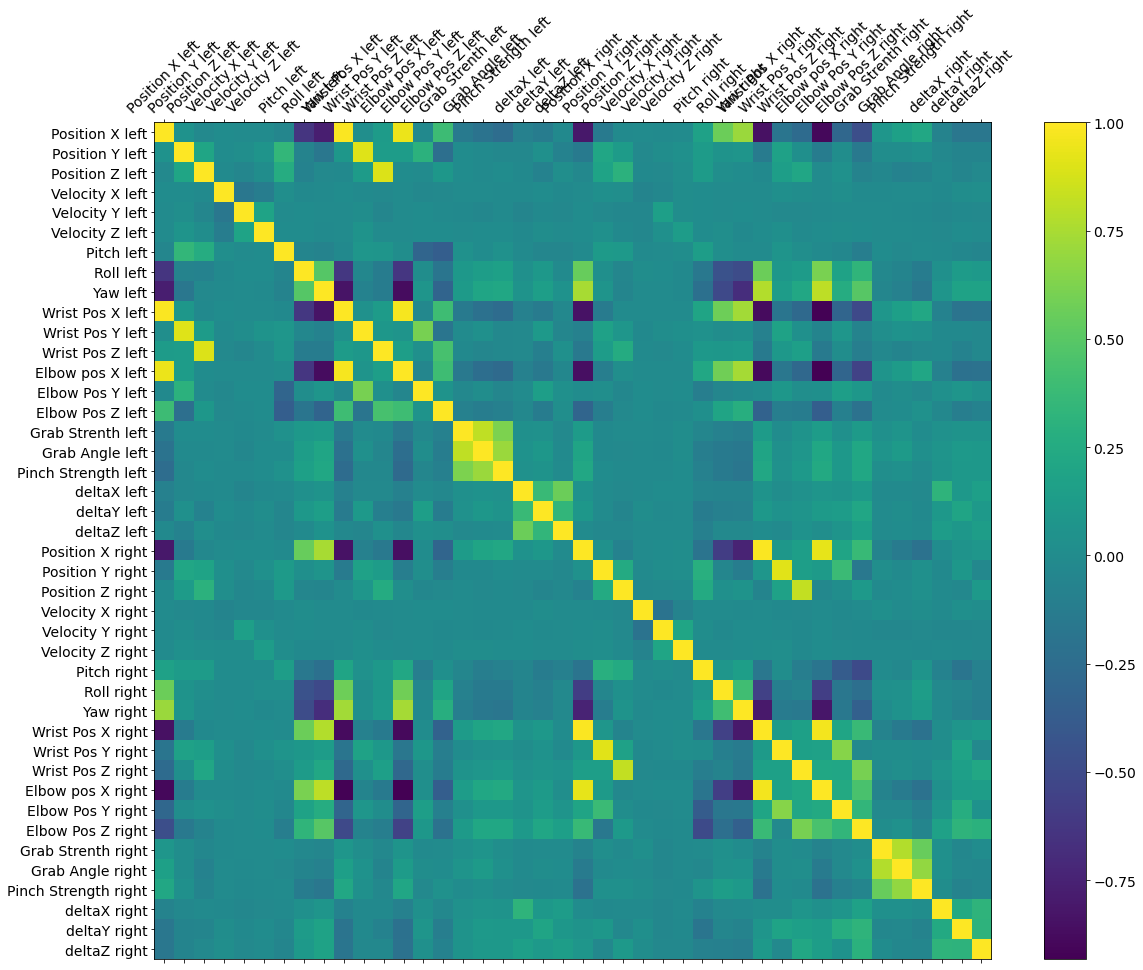

In [13]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df_numeric_values.corr(), fignum=f.number)
plt.xticks(range(df_numeric_values.shape[1]), df_numeric_values.columns, fontsize=14, rotation=45)
plt.yticks(range(df_numeric_values.shape[1]), df_numeric_values.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
# plt.title('Correlation Matrix', fontsize=16);

In [14]:
# rs = np.random.RandomState(0)
corr = df_numeric_values.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

lets check the out data is good

In [15]:
print(df['Type right'].value_counts())
print("---------------------------------------------------")
print(df['Type left'].value_counts())
print("---------------------------------------------------")
print((df['Type right'] == df['Type left']).value_counts())

2    5556
3    5511
1    2552
Name: Type right, dtype: int64
---------------------------------------------------
2    5556
3    5511
1    2552
Name: Type left, dtype: int64
---------------------------------------------------
True    13619
dtype: int64


In [16]:
df['Type'] = df['Type right']
df.drop(['Type left', 'Type right'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13619 entries, 0 to 13618
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Position X left       13619 non-null  float64
 1   Position Y left       13619 non-null  float64
 2   Position Z left       13619 non-null  float64
 3   Velocity X left       13619 non-null  float64
 4   Velocity Y left       13619 non-null  float64
 5   Velocity Z left       13619 non-null  float64
 6   Pitch left            13619 non-null  float64
 7   Roll left             13619 non-null  float64
 8   Yaw left              13619 non-null  float64
 9   Wrist Pos X left      13619 non-null  float64
 10  Wrist Pos Y left      13619 non-null  float64
 11  Wrist Pos Z left      13619 non-null  float64
 12  Elbow pos X left      13619 non-null  float64
 13  Elbow Pos Y left      13619 non-null  float64
 14  Elbow Pos Z left      13619 non-null  float64
 15  Grab Strenth left  

In [17]:
df_validation['Type'] = df_validation['Type right']
df_validation.drop(['Type left', 'Type right'], axis=1, inplace=True)
df_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Position X left       3687 non-null   float64
 1   Position Y left       3687 non-null   float64
 2   Position Z left       3687 non-null   float64
 3   Velocity X left       3687 non-null   float64
 4   Velocity Y left       3687 non-null   float64
 5   Velocity Z left       3687 non-null   float64
 6   Pitch left            3687 non-null   float64
 7   Roll left             3687 non-null   float64
 8   Yaw left              3687 non-null   float64
 9   Wrist Pos X left      3687 non-null   float64
 10  Wrist Pos Y left      3687 non-null   float64
 11  Wrist Pos Z left      3687 non-null   float64
 12  Elbow pos X left      3687 non-null   float64
 13  Elbow Pos Y left      3687 non-null   float64
 14  Elbow Pos Z left      3687 non-null   float64
 15  Grab Strenth left    

shuffle the data

In [18]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Position X left,Position Y left,Position Z left,Velocity X left,Velocity Y left,Velocity Z left,Pitch left,Roll left,Yaw left,Wrist Pos X left,...,Elbow pos X right,Elbow Pos Y right,Elbow Pos Z right,Grab Strenth right,Grab Angle right,Pinch Strength right,deltaX right,deltaY right,deltaZ right,Type
0,143.5289,212.2962,-19.900570,104.279300,483.11960,52.33307,1.001350,-0.656428,-1.073298,195.5176,...,-331.2137,-38.18494,63.250170,1.0,3.063579,1.0,2.10307,3.2271,0.624180,2
1,120.7355,213.1423,8.611112,-11.086800,-70.12826,-52.26726,1.756871,-1.241714,-2.026337,150.2766,...,-267.2714,-79.43314,-1.393899,0.0,0.000000,0.0,0.68210,0.4605,0.500430,3
2,120.5403,178.1345,71.609020,-74.161230,162.44950,-218.16200,1.160114,-1.105606,-0.800520,156.2942,...,-292.9944,-46.31137,14.778410,0.0,0.000000,0.0,0.26007,2.7935,1.433404,3
3,-101.6580,262.9103,25.264520,-4.741856,107.93570,101.33760,0.951029,1.671287,-0.004263,-111.3119,...,298.2602,47.63605,22.935030,0.0,0.000000,0.0,0.03050,0.9944,0.717150,3
4,148.7870,255.6893,186.449900,-25.047840,18.72508,60.40045,1.261294,-0.943846,-0.789947,182.8419,...,-414.5233,-10.69785,22.554200,0.0,0.483445,0.0,0.55260,1.0159,0.244450,2


In [76]:
df = stam_train.copy()
df_validation = stam_val.copy()

split our data to train and test

In [77]:
y = df["Type"]
X = df.drop(["Type"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

In [78]:
y_validation = df_validation["Type"]
X_validation = df_validation.drop(["Type"], axis=1)

before we import our models lets use pca to decrease the number of the Dimensions

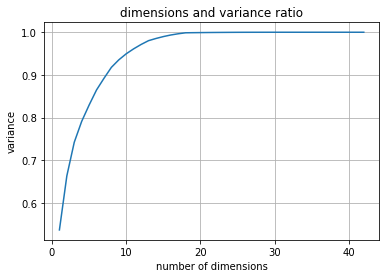

In [79]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
x = np.arange(1, len(cumsum)+1)
plt.plot(x, cumsum)
plt.xlabel('number of dimensions')
plt.ylabel('variance')
plt.title('dimensions and variance ratio')
plt.grid(True)
plt.show()

In [80]:
pca = PCA(n_components=0.99, random_state=0)
pca.fit(X_train)
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

In [81]:
X_validation_reduced = pca.transform(X_validation)


# models

## naive bayes

In [82]:
gnb_clf = GaussianNB()
gnb_clf.fit(X_train_reduced, y_train)
predictions = gnb_clf.predict(X_test_reduced)

In [83]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))
gnb_accuracy = metrics.accuracy_score(y_test, predictions)
print(gnb_accuracy)
gnb_eval = evaluate_pred(confusion_matrix(y_test, predictions))
print("evaluate =", gnb_eval)

[[ 731   16    6]
 [  11 1063  630]
 [  21  316 1292]]
              precision    recall  f1-score   support

           1       0.96      0.97      0.96       753
           2       0.76      0.62      0.69      1704
           3       0.67      0.79      0.73      1629

    accuracy                           0.76      4086
   macro avg       0.80      0.80      0.79      4086
weighted avg       0.76      0.76      0.75      4086

0.7552618697993148
evaluate = 2086


## random forest

In [84]:
rf_clf = RandomForestClassifier(random_state=33, n_estimators=250)
rf_clf.fit(X_train_reduced, y_train)
predictions = rf_clf.predict(X_test_reduced)

In [85]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))
rf_accuracy = metrics.accuracy_score(y_test, predictions)
print(rf_accuracy)
rf_eval = evaluate_pred(confusion_matrix(y_test, predictions))
print("evaluate =", rf_eval)

[[ 751    1    1]
 [   1 1524  179]
 [   5  198 1426]]
              precision    recall  f1-score   support

           1       0.99      1.00      0.99       753
           2       0.88      0.89      0.89      1704
           3       0.89      0.88      0.88      1629

    accuracy                           0.91      4086
   macro avg       0.92      0.92      0.92      4086
weighted avg       0.91      0.91      0.91      4086

0.9057758198727361
evaluate = 3316


## KNN

In [86]:
#first lets find the optimum K 
err_rate = []
for i in range(1,30):
    k = KNeighborsClassifier(n_neighbors=i)
    k.fit(X_train_reduced, y_train)
    pred_i=k.predict(X_test_reduced)

    err_rate.append(np.mean(pred_i !=y_test))
index = err_rate.index(min(err_rate)) + 1
index

8

In [87]:
nbrs = KNeighborsClassifier(n_neighbors=index)
nbrs.fit(X_train_reduced, y_train)
predictions = nbrs.predict(X_test_reduced)

In [88]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))
knn_accuracy = metrics.accuracy_score(y_test, predictions)
print(knn_accuracy)
knn_eval = evaluate_pred(confusion_matrix(y_test, predictions))
print("evaluate =", knn_eval)

[[ 746    5    2]
 [   0 1438  266]
 [   6  265 1358]]
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       753
           2       0.84      0.84      0.84      1704
           3       0.84      0.83      0.83      1629

    accuracy                           0.87      4086
   macro avg       0.89      0.89      0.89      4086
weighted avg       0.87      0.87      0.87      4086

0.8668624571708272
evaluate = 2998


## SVC

In [89]:
svc_clf = SVC()
svc_clf.fit(X_train_reduced, y_train)
predictions = svc_clf.predict(X_test_reduced)

In [90]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))
svc_accuracy = metrics.accuracy_score(y_test, predictions)
print(svc_accuracy)
svc_eval = evaluate_pred(confusion_matrix(y_test, predictions))
print("evaluate =", svc_eval)

[[ 752    1    0]
 [   5 1408  291]
 [  11  287 1331]]
              precision    recall  f1-score   support

           1       0.98      1.00      0.99       753
           2       0.83      0.83      0.83      1704
           3       0.82      0.82      0.82      1629

    accuracy                           0.85      4086
   macro avg       0.88      0.88      0.88      4086
weighted avg       0.85      0.85      0.85      4086

0.8543808125305923
evaluate = 2896


## adaboost

In [91]:
ada_clf = AdaBoostClassifier(rf_clf, learning_rate=0.1, n_estimators=300, random_state=33)
ada_clf.fit(X_train_reduced, y_train)
predictions = ada_clf.predict(X_test_reduced)

In [92]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))
ada_accuracy = metrics.accuracy_score(y_test, predictions)
print(ada_accuracy)
ada_eval = evaluate_pred(confusion_matrix(y_test, predictions))
print("evaluate =", ada_eval)

[[ 750    1    2]
 [   1 1512  191]
 [   7  197 1425]]
              precision    recall  f1-score   support

           1       0.99      1.00      0.99       753
           2       0.88      0.89      0.89      1704
           3       0.88      0.87      0.88      1629

    accuracy                           0.90      4086
   macro avg       0.92      0.92      0.92      4086
weighted avg       0.90      0.90      0.90      4086

0.9023494860499266
evaluate = 3288


## logistic regression 

In [93]:
lr_clf = LogisticRegression()
lr_clf = lr_clf.fit(X_train_reduced, y_train)
predictions = lr_clf.predict(X_test_reduced)

In [94]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))
lr_accuracy = metrics.accuracy_score(y_test, predictions)
print(lr_accuracy)
lr_eval = evaluate_pred(confusion_matrix(y_test, predictions))
print("evaluate =", lr_eval)

[[ 730   16    7]
 [  25 1335  344]
 [  36  672  921]]
              precision    recall  f1-score   support

           1       0.92      0.97      0.95       753
           2       0.66      0.78      0.72      1704
           3       0.72      0.57      0.63      1629

    accuracy                           0.73      4086
   macro avg       0.77      0.77      0.77      4086
weighted avg       0.73      0.73      0.73      4086

0.7307880567792462
evaluate = 1886


In [95]:
dt = {}
dt.update({"model name" : ["random forest", "knn", "svc", "adaboost", "nasive bayes", "logistic regression"]})
dt.update({"model accuracy" : [rf_accuracy, knn_accuracy, svc_accuracy, ada_accuracy, gnb_accuracy, lr_accuracy]})
dt.update({"model evaluate" : [rf_eval, knn_eval, svc_eval, ada_eval, gnb_eval, lr_eval]})
dt.update({"model object" : [rf_clf, nbrs, svc_clf, ada_clf, gnb_clf, lr_clf]})
df_models = pd.DataFrame(data = dt)
df_models = df_models.sort_values(by=['model accuracy'], ascending=False)
df_models =  df_models.set_index(np.arange(1,len(df_models)+1))
# df.iloc[:, :len(df.columns)-1]
df_models  #-if you want to show all the df

,model name,model accuracy,model evaluate,model object
1,random forest,0.905776,3316,"(DecisionTreeClassifier(max_features='auto', r..."
2,adaboost,0.902349,3288,"((DecisionTreeClassifier(max_features='auto', ..."
3,knn,0.866862,2998,KNeighborsClassifier(n_neighbors=8)
4,svc,0.854381,2896,SVC()
5,nasive bayes,0.755262,2086,GaussianNB()
6,logistic regression,0.730788,1886,LogisticRegression()


In [96]:
best_model = df_models.iloc[0, len(df_models.columns)-1]
best_model

RandomForestClassifier(n_estimators=250, random_state=33)

In [97]:
predictions = best_model.predict(X_validation_reduced)

In [98]:
print(confusion_matrix(y_validation, predictions))
print(classification_report(y_validation,predictions))
print(metrics.accuracy_score(y_validation, predictions))
best_eval = evaluate_pred(confusion_matrix(y_validation, predictions))
print("evaluate =", best_eval)

[[ 726    1    2]
 [   0 1305  177]
 [   1  677  798]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       729
           2       0.66      0.88      0.75      1482
           3       0.82      0.54      0.65      1476

    accuracy                           0.77      3687
   macro avg       0.82      0.81      0.80      3687
weighted avg       0.79      0.77      0.76      3687

0.7672904800650936
evaluate = 1971
